In [1]:
from datasets import load_from_disk


In [3]:
dataset=load_from_disk('/shared/how2_all.dataset').with_format('torch')

In [32]:
dataset[392]['vid'].shape

torch.Size([2048])

In [45]:
# Train string encoders
en_data = [" ".join(x) for x in dataset['en']]
pt_data = [" ".join(x) for x in dataset['pt']]
sm_data = [" ".join(x) for x in dataset['sm'] if x]

In [59]:
#en_training_corpus = (
#    en_data[i : i + 1000]
#    for i in range(0, len(en_data), 1000)
#)

In [48]:
from transformers import AutoTokenizer

#old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
#old_tokenizer.encode(" ".join(dataset[0]['sm']))

In [146]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
                    vocab_size=8192)

In [117]:
tokenizer.train_from_iterator(sm_data,trainer)

In [118]:
tokenizer.save('sm_tokenizer')

In [119]:
tokenizer.get_vocab_size()
tokenizer.get_vocab()

{'apped': 7302,
 'calves': 7902,
 'robe': 4426,
 'crystal': 4703,
 'fant': 5226,
 'fortune': 4575,
 'loveall': 5919,
 'birdcage': 6483,
 'beats': 2749,
 'spread': 4128,
 'bear': 1835,
 'testing': 4828,
 'suffering': 7187,
 'outdoorsman': 7229,
 'therap': 758,
 'mouse': 4207,
 'nicely': 7917,
 'carpenter': 4389,
 'feren': 3278,
 'exer': 245,
 'cir': 1033,
 'things': 2047,
 'mechan': 1241,
 'colepsy': 7348,
 'shelter': 7977,
 'angelo': 8171,
 'shine': 4412,
 'pod': 2066,
 'leading': 4344,
 'dynam': 5716,
 'apples': 6407,
 'orchid': 7346,
 'equine': 3059,
 'instructor': 258,
 'noseblunt': 7573,
 'cu': 462,
 'eliminate': 4377,
 'word': 1586,
 'ics': 604,
 'comers': 7845,
 'rate': 4108,
 'nurse': 4030,
 'sound': 1458,
 'swee': 6844,
 'intervie': 3008,
 'garlic': 2293,
 'planets': 7790,
 'stands': 6477,
 'scheduling': 3628,
 'bloo': 5217,
 'wondering': 7969,
 'antiques': 3730,
 'ank': 1342,
 'cy': 537,
 'peanut': 4727,
 'cages': 5944,
 'editor': 3481,
 'listening': 3779,
 'promin': 7864,
 'i

In [1]:
#sm_tokenizer.encode(sm_data[23])
#sm_data

In [150]:
from transformers import PreTrainedTokenizerFast
sm_tokenizer = PreTrainedTokenizerFast(tokenizer_file="sm_tokenizer")
en_tokenizer = PreTrainedTokenizerFast(tokenizer_file="en_tokenizer")
pt_tokenizer = PreTrainedTokenizerFast(tokenizer_file="pt_tokenizer")

In [155]:
import torch
def dataset_reorg(batch):
    data_dict = {
        'vid': {'indices': torch.arange(1,len(batch['vid'])+1),
                'values': batch['vid']},
        'aud': {'values': batch['aud']},
        'en': {'tokens': en_tokenizer.encode(" ".join(batch['en']))},
        'pt': {'tokens': pt_tokenizer.encode(" ".join(batch['pt']))},
        'sm': {'tokens': sm_tokenizer.encode(" ".join(batch['sm']) if batch['sm'] else "")}
    }
    return data_dict


In [271]:
def hotfix(batch):
    batch['vid']['indices'] = batch['vid']['indices'] + 1
    return(batch)

In [273]:
#dataset = dataset.map(dataset_reorg)
dataset = dataset.map(hotfix, num_proc=16)

Map (num_proc=16):   0%|          | 0/184949 [00:00<?, ? examples/s]

In [1]:
#dataset.save_to_disk('/shared/how2_all_proc')

In [1]:
from datasets import load_from_disk

dataset = load_from_disk('/shared/how2_all_proc')

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))

In [3]:
import encoders
from encoders import MultimodalCollator
import importlib

importlib.reload(encoders)
#importlib.reload(model)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [4]:
encoder_configs = {'aud':{'type':'PatchEncoder',
                         'max_tokens':320, 
                         'patch_size':(32,8)},
                   'en':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'pt':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'sm':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'vid':{'type':'TabularEncoder',
                          "num_embeddings":2048,
                          'max_tokens':2048,
                         },
                  }

In [5]:
modality_config = {'aud':{'type':'matrix','pad_len':2048, 'max_channels':40},
                   'en':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'pt':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'sm':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'vid':{'type':'sequence','pad_len':2048},
                  }

In [6]:
mc = MultimodalCollator(modality_config)

In [7]:
mc.modality_collators.keys()
#sample = dataset[0]
#sample.pop('name',None)
#sample.keys()

dict_keys(['aud', 'en', 'pt', 'sm', 'vid'])

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
                        dataset, shuffle=True, collate_fn=mc,
                        batch_size=8,
                        prefetch_factor=4, num_workers=2
                )
dl_iter = iter(train_dataloader)

In [9]:
#from encoders import MultimodalCollator
import model
from model import MFDOOM
import importlib
importlib.reload(model)
importlib.reload(encoders)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [10]:
doom = MFDOOM(encoder_configs, 512,4, device="cpu", num_fusion_tokens=256)

[320, 256, 256, 256, 2048]


In [11]:
loss = doom(next(dl_iter))

frozenset({'en', 'aud'}):tensor([ True, False, False,  True,  True,  True,  True,  True])
frozenset({'aud', 'pt'}):tensor([ True, False, False,  True,  True,  True,  True,  True])
frozenset({'aud', 'sm'}):tensor([ True, False, False,  True, False,  True,  True,  True])
frozenset({'vid', 'aud'}):tensor([ True, False, False,  True,  True,  True,  True,  True])
frozenset({'en', 'pt'}):tensor([True, True, True, True, True, True, True, True])
frozenset({'en', 'sm'}):tensor([ True, False, False,  True, False,  True,  True,  True])
frozenset({'vid', 'en'}):tensor([True, True, True, True, True, True, True, True])
frozenset({'pt', 'sm'}):tensor([ True, False, False,  True, False,  True,  True,  True])
frozenset({'vid', 'pt'}):tensor([True, True, True, True, True, True, True, True])
frozenset({'vid', 'sm'}):tensor([ True, False, False,  True, False,  True,  True,  True])


In [12]:
loss

{'aud': tensor([[ 0.9782,  1.5378,  1.1478,  ..., -0.5704, -0.1331, -0.9546],
         [ 1.2143,  1.6098,  1.2620,  ..., -0.3436, -0.1274, -0.7023],
         [ 1.1824,  1.5847,  1.2546,  ..., -0.3282, -0.1064, -0.6970],
         ...,
         [ 0.9506,  1.4736,  1.1385,  ..., -0.6052, -0.1057, -0.8709],
         [ 0.9985,  1.5380,  1.1869,  ..., -0.5474, -0.0717, -0.9246],
         [ 1.0577,  1.4771,  1.1838,  ..., -0.6202, -0.1457, -0.8686]],
        grad_fn=<SqueezeBackward1>),
 'en': tensor([[-2.5660,  1.5827,  0.6431,  ...,  2.0139, -0.0996, -2.1563],
         [-2.6269,  1.5470,  0.6996,  ...,  2.0540, -0.0979, -2.0989],
         [-2.7571,  1.4734,  0.6848,  ...,  2.0999, -0.0492, -2.0235],
         ...,
         [-2.9651,  1.3009,  0.3408,  ...,  2.1502, -0.1698, -2.1329],
         [-2.8513,  1.3350,  0.2453,  ...,  2.1776, -0.1093, -2.2521],
         [-2.7422,  1.4333,  0.2149,  ...,  2.2102,  0.0631, -2.3874]],
        grad_fn=<SqueezeBackward1>),
 'pt': tensor([[-0.3984, -0.227

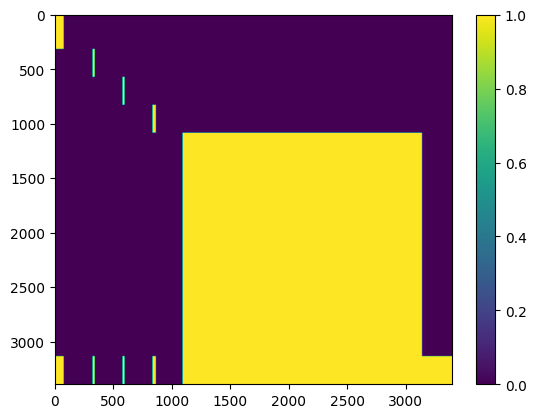

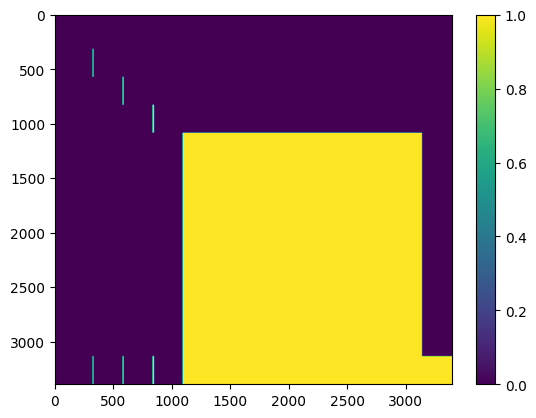

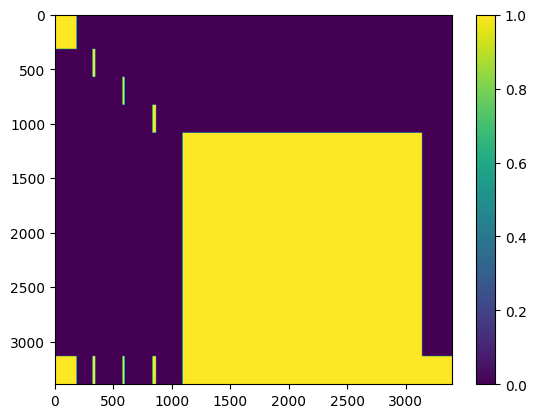

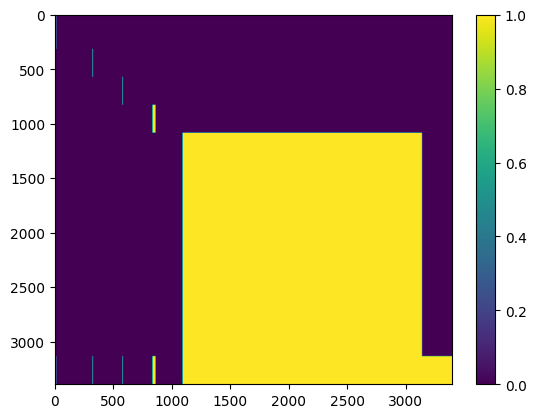

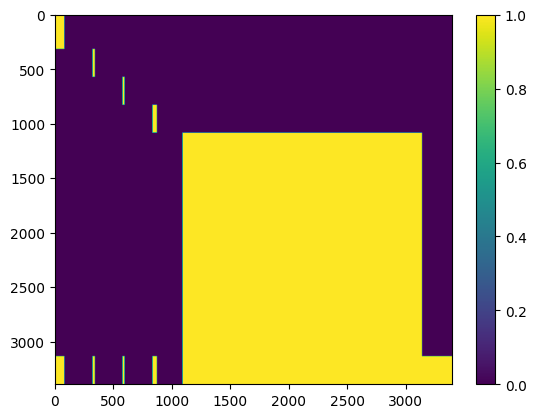

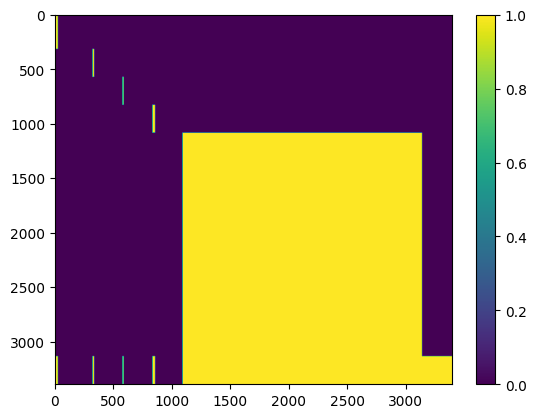

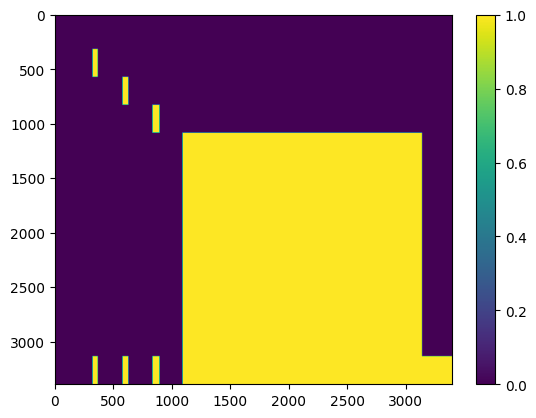

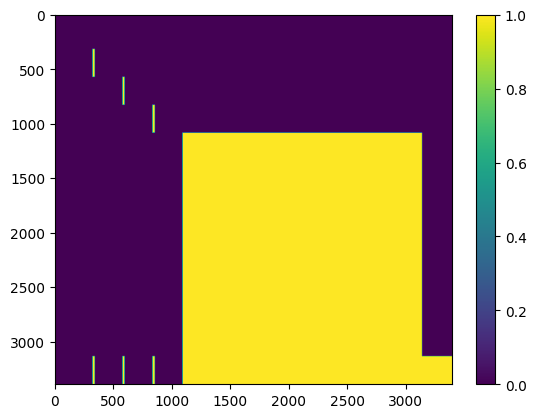

In [12]:
import matplotlib.pyplot as plt
import torch
from einops import repeat
#plt.imshow(~pool, aspect='auto')
plt.clf()
heads = 4
bs = 8
sim = repeat(torch.ones_like(zorro), "i j -> b h i j", h = heads, b = bs)
sim = sim.masked_fill(zorro, 0)
key_padding_mask = repeat(pad, "b i -> b h j i", h=heads, j=sim.shape[-2])
sim = sim.masked_fill(key_padding_mask, 0)
sim
for i in range(8):
    plt.figure(i)
    plt.imshow(sim[i,0,:,:], aspect = 'auto')
    plt.colorbar()

In [ ]:
plt.imshow(zorro)
doom(next(dl_iter))

In [1]:
2048+256+256+128+320+16-3152

-128

In [6]:
fs = frozenset({'a','b'})
#a,b =x
a,b = fs
test2(a,b)

b---a


In [5]:
def test(x):
    return x+'_'
def test2(a,b):
    print(a + '---' + b)
test2(*[test(x) for x in fs])

b_---a_
